# Sentiment Analysis on Tweets

Welcome to this sentiment analysis project! In this notebook, we explore how tweet text can be used to classify sentiment as **Positive** or **Negative** using machine learning models.

## Objectives

- Perform **exploratory data analysis (EDA)** on tweet structure and sentiment
- Engineer features like **text length**, **polarity**, and **keyword presence**
- Train and evaluate **Logistic Regression** and **Random Forest** classifiers
- Interpret model decisions using **SHAP values**
- Compare model performance and identify strengths and limitations

## Dataset

- ~1.27 million tweets
- Balanced sentiment classes: Negative (0), Positive (1)
- Neutral class excluded from modeling

## What You'll See

- Visual insights into tweet length, sentiment distribution, and polarity
- Confusion matrices and classification reports
- SHAP-based feature importance
- Sample predictions and error analysis

Let’s dive in and explore how language reflects emotion—and how models learn to detect it.


In [2]:
# =====================================================================
# Day7_SentimentAnalysis.ipynb
# =====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import shap
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# -----------------------------------------------------
# 1 Data Loading
# -----------------------------------------------------
data_dir = Path("data/processed")
train_df = pd.read_csv(data_dir/"train.csv")
test_df  = pd.read_csv(data_dir/"test.csv")

train_df.sample(5)

,clean_text,label
489549,went la today â fun fun fun dont want weekend end,0
595452,never reply any1 see glasgow nxt week,1
154881,im dissapointed one library computers doesnt a...,0
1014659,cut lose mark,0
826062,tired last nite aunties lol,1


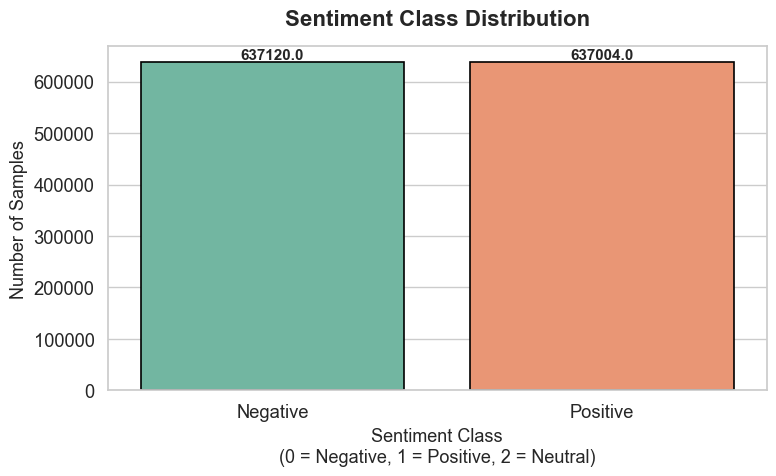

In [3]:
# ------------------------------
# Target distribution
# ------------------------------
# Set a modern, clean style
sns.set(style="whitegrid", font_scale=1.2)

# Define custom color palette for better contrast
custom_palette = sns.color_palette("Set2")

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    x='label',
    data=train_df,
    palette=custom_palette,
    edgecolor='black',
    linewidth=1.2
)

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Improve axis labels and title
ax.set_title('Sentiment Class Distribution', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Sentiment Class\n(0 = Negative, 1 = Positive, 2 = Neutral)', fontsize=13)
ax.set_ylabel('Number of Samples', fontsize=13)

# Optional: Customize ticks
ax.set_xticklabels(['Negative', 'Positive', 'Neutral'])

# Tight layout for better spacing
plt.tight_layout()
plt.show()


#### Sentiment Class Distribution Analysis

##### Overview
This analysis examines the distribution of sentiment classes in a dataset used for natural language processing tasks. The bar chart titled **"Sentiment Class Distribution"** presents the number of samples for two sentiment categories:

- **Negative (0)**: 637,120 samples
- **Positive (1)**: 637,004 samples

>  Note: The chart mentions a third class, **Neutral (2)**, but no data is shown for it.


##### Key Observations

- **Balanced Dataset**:  
  The dataset is nearly perfectly balanced between Negative and Positive sentiment classes:
  - Difference: Only **116 samples**, which is **< 0.01%** of the total.
  - This balance is ideal for training binary classification models, reducing bias toward either class.

- **Class Labels**:  
  - The x-axis labels clarify that:
    - `0 = Negative`
    - `1 = Positive`
    - `2 = Neutral` (not represented in the chart)

- **Visual Encoding**:
  - **Teal** bar for Negative
  - **Orange** bar for Positive
  - Both bars reach approximately **637,000 samples**, indicating visual symmetry and class parity.


##### Implications for Modeling

-  **Model Fairness**:  
  Balanced class distribution helps prevent skewed predictions and improves generalization.

-  **Evaluation Metrics**:  
  Metrics like accuracy, precision, recall, and F1-score will be more reliable due to class parity.

-  **Neutral Class Missing**:  
  If Neutral samples exist but are excluded from this chart, it may affect:
  - Multi-class classification strategies
  - Label encoding and preprocessing steps
  - Interpretation of model outputs


##### Summary

The dataset shows a highly balanced distribution between Negative and Positive sentiment classes, which is ideal for binary sentiment classification. However, the absence of Neutral class data in the chart warrants further investigation. Overall, the dataset is well-suited for fair and robust model training.



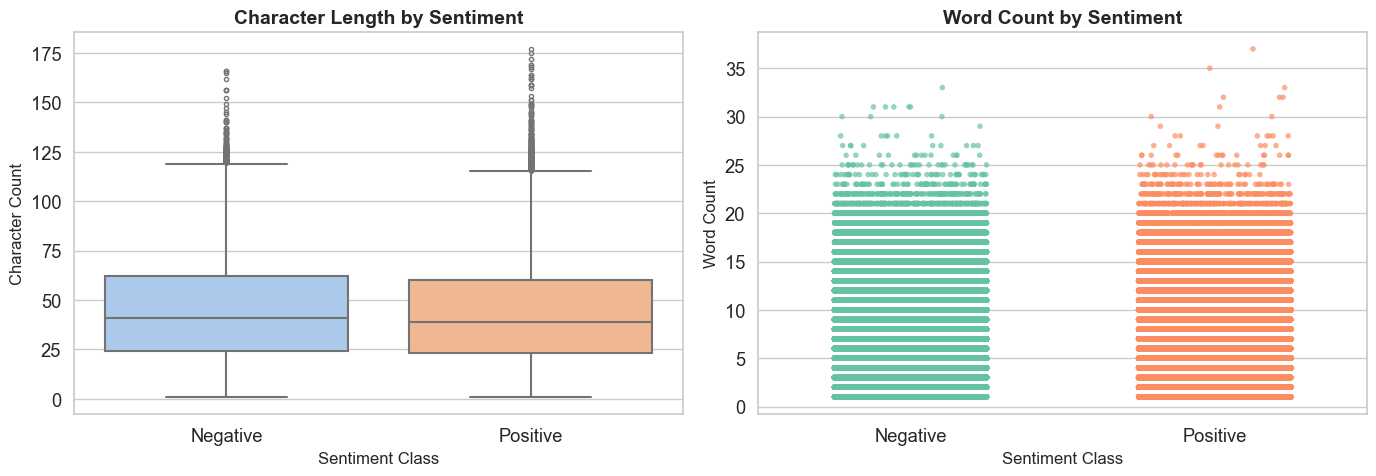

In [4]:

# ------------------------------
# Text length metrics
# ------------------------------
# Compute text metrics
train_df['char_len'] = train_df['clean_text'].apply(len)
train_df['word_count'] = train_df['clean_text'].str.split().apply(len)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Boxplot: Character length
sns.boxplot(
    y='char_len',
    x='label',
    data=train_df,
    ax=axes[0],
    palette='pastel',
    linewidth=1.5,
    fliersize=3
)
axes[0].set_title("Character Length by Sentiment", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Sentiment Class", fontsize=12)
axes[0].set_ylabel("Character Count", fontsize=12)
axes[0].set_xticklabels(['Negative', 'Positive', 'Neutral'])

# Stripplot: Word count
sns.stripplot(
    y='word_count',
    x='label',
    data=train_df,
    ax=axes[1],
    palette='Set2',
    jitter=0.25,
    size=4,
    alpha=0.7
)
axes[1].set_title("Word Count by Sentiment", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Sentiment Class", fontsize=12)
axes[1].set_ylabel("Word Count", fontsize=12)
axes[1].set_xticklabels(['Negative', 'Positive', 'Neutral'])

# Tight layout and display
plt.tight_layout()
plt.show()



### Text Length Analysis by Sentiment Class

#### Overview
This analysis explores how text length—measured by character count and word count—varies across sentiment classes in a natural language processing dataset. Two side-by-side plots provide insights:

- **Left Plot**: Box plot of character count by sentiment
- **Right Plot**: Dot plot of word count by sentiment

Sentiment classes analyzed:
- **Negative (0)**
- **Positive (1)**


#### Character Count by Sentiment

##### Observations

- **Higher Median for Negative Sentiment**:  
  Negative texts tend to be longer in terms of character count.

- **Wider Spread**:  
  The interquartile range (IQR) for Negative sentiment is broader, indicating more variability in text length.

- **Outliers**:  
  Negative sentiment shows more extreme outliers—some texts are significantly longer than the rest.

##### Implications

- Negative sentiment may involve more detailed or emotionally charged language.
- Longer texts could reflect complaints, explanations, or rants, which are common in negative feedback.
- Preprocessing steps (e.g., truncation, padding) should account for this variability.


#### Word Count by Sentiment

##### Observations

- **Similar Distributions**:  
  Both sentiment classes show comparable word count distributions.

- **Lower Range Concentration**:  
  Most texts fall within a relatively low word count range, suggesting brevity across the dataset.

- **Dot Plot Density**:  
  Slightly denser clustering in lower word counts for both classes, with no major skew.

##### Implications

- Despite character count differences, word count remains consistent—possibly due to differences in word length or punctuation.
- Tokenization strategies should be robust to handle character-heavy but word-light texts.

#### Summary

Text length varies meaningfully across sentiment classes:
- Negative sentiment texts are longer and more variable in character count.
- Word count remains relatively consistent across classes.
These insights can inform preprocessing, feature selection, and model architecture decisions for sentiment analysis tasks.



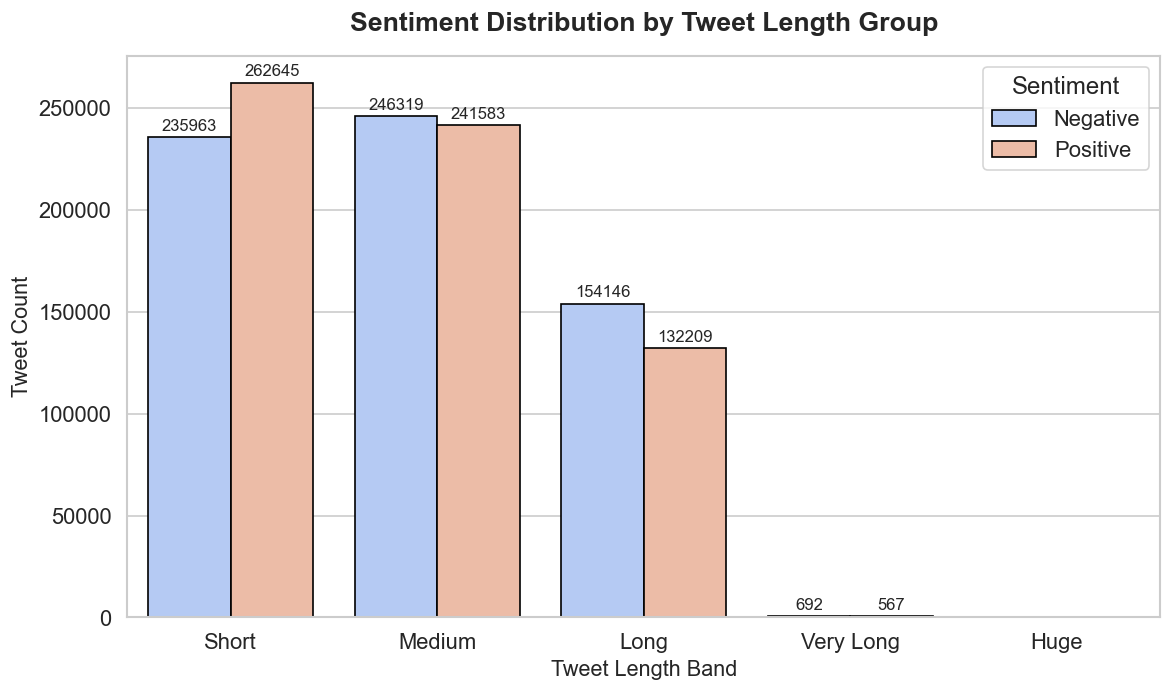

In [5]:
# ------------------------------
# Sentiment per Tweet Length band
# ------------------------------
# Define tweet length bands
train_df['len_band'] = pd.cut(
    train_df['word_count'],
    bins=[0, 5, 10, 20, 40, 100],
    labels=['Short', 'Medium', 'Long', 'Very Long', 'Huge']
)

# Create the plot
plt.figure(figsize=(10, 6), dpi=120)
ax = sns.countplot(
    data=train_df,
    x='len_band',
    hue='label',
    palette='coolwarm',
    edgecolor='black'
)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=2)

# Improve title and axis labels
ax.set_title('Sentiment Distribution by Tweet Length Group', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Tweet Length Band', fontsize=13)
ax.set_ylabel('Tweet Count', fontsize=13)
ax.legend(title='Sentiment', labels=['Negative', 'Positive'])

# Tight layout
plt.tight_layout()
plt.show()


#### Sentiment Distribution by Tweet Length Group

##### Overview
This analysis explores how sentiment (Negative vs. Positive) varies across different tweet length categories. The bar chart titled **"Sentiment Distribution by Tweet Length Group"** breaks down tweet counts by sentiment across five length bands:

- **Short**
- **Medium**
- **Long**
- **Very Long**
- **Huge**

Each band includes counts for:
- **Negative (blue)**
- **Positive (orange)**

##### Tweet Counts by Length Group

| Length Group | Negative Tweets | Positive Tweets |
|--------------|------------------|------------------|
| Short        | 235,963          | 262,645          |
| Medium       | 246,319          | 241,583          |
| Long         | 154,146          | 132,209          |
| Very Long    | 692              | 567              |
| Huge         | 0                | 0                |


##### Key Observations

##### 1. **Short Tweets Favor Positivity**
- Positive tweets outnumber Negative ones in the **Short** category.
- Suggests that brief expressions tend to be more positive—possibly due to casual greetings, affirmations, or promotional content.

##### 2. **Medium Tweets Are Balanced**
- Near parity between Negative and Positive tweets.
- Indicates that medium-length tweets are neutral territory for sentiment expression.

##### 3. **Longer Tweets Skew Negative**
- **Long** and **Very Long** tweets show a clear dominance of Negative sentiment.
- Longer tweets may be used for complaints, detailed feedback, or emotional venting.

##### 4. **No Huge Tweets**
- The **Huge** category has zero entries, implying either:
  - A hard character limit (e.g., Twitter’s 280-character cap)
  - Filtering or preprocessing removed extremely long texts


##### Behavioral Insights

- **Length as a Sentiment Proxy**:  
  Tweet length can act as a weak signal for sentiment:
  - Short → More likely Positive
  - Long → More likely Negative

- **Platform Constraints**:  
  The absence of Huge tweets reflects platform limitations and should be considered when designing models or collecting data.

- **User Intent**:  
  Longer tweets may reflect deliberate effort to express dissatisfaction, while shorter tweets may be spontaneous or promotional.

##### Summary

Tweet length correlates with sentiment in meaningful ways:
- Short tweets lean Positive
- Long tweets lean Negative
- Medium tweets are balanced
These patterns can inform feature engineering, model design, and behavioral interpretation in sentiment analysis tasks.



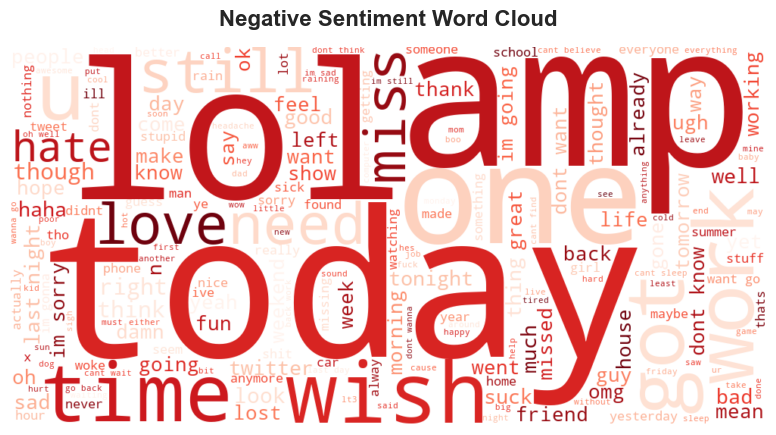

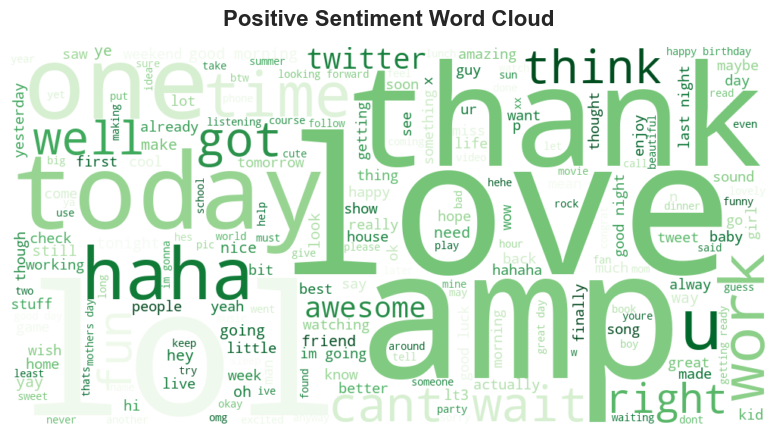

In [6]:
# ------------------------------
# Word Clouds
# ------------------------------

# Define color maps for each sentiment
colormaps = {
    0: 'Reds',     # Negative
    1: 'Greens',   # Positive
    }

# Generate and display word clouds
for lbl, title in zip([0, 1], ['Negative', 'Positive']):
    text = " ".join(train_df[train_df.label == lbl].clean_text)
    wc = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap=colormaps[lbl],
        max_words=200,
        contour_color='black',
        contour_width=1.5
    ).generate(text)

    plt.figure(figsize=(8, 5), dpi=100)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{title} Sentiment Word Cloud', fontsize=16, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()


#### Negative Sentiment Word Cloud

##### Prominent Words
- "today", "amp", "one", "wish", "work", "hate", "miss", "look", "still", "got", "think"

##### Key Insights
- Frequent use of emotionally charged or reflective words.
- Words like "hate", "miss", "wish" suggest dissatisfaction or longing.
- "amp" likely reflects HTML encoding artifacts.


#### Positive Sentiment Word Cloud

##### Prominent Words
- "love", "haha", "thank", "play", "fun", "awesome", "hope", "weekend", "day", "well"

##### Key Insights
- Words reflect joy, gratitude, and anticipation.
- Informal tone ("haha", "cant", "u") suggests casual positivity.
- "amp" again appears—needs preprocessing attention.

#### Final Summary

These visual insights reveal nuanced relationships between sentiment and text characteristics:
- Balanced sentiment classes support fair modeling.
- Negative texts tend to be longer and more expressive.
- Tweet length correlates with sentiment polarity.
- Word clouds highlight emotional and thematic patterns.

Together, these findings can guide feature engineering, preprocessing, and model design for robust sentiment analysis pipelines.



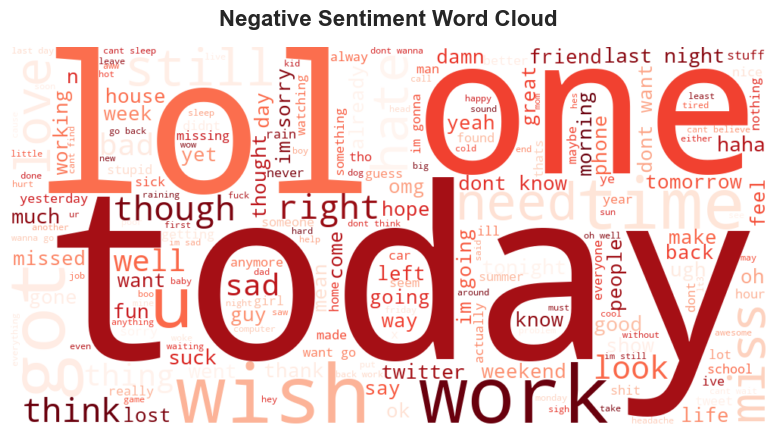

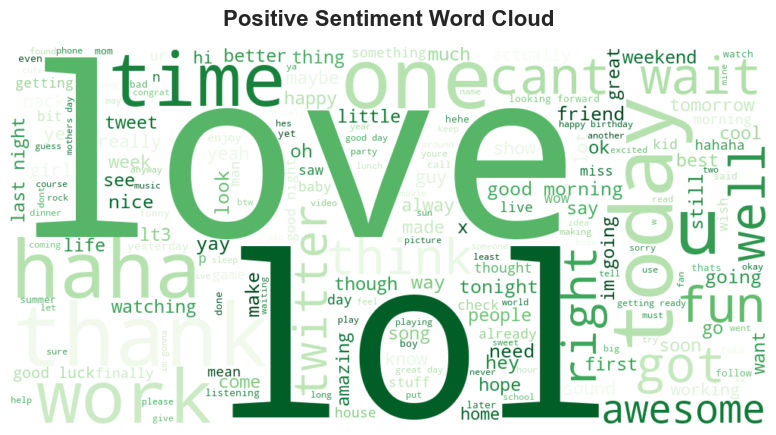

In [7]:
# ------------------------------
# Word Clouds after removing "amp" 
# ------------------------------
# Words to remove
words_to_remove = ['amp']

# Remove the words
for word in words_to_remove:
    train_df['clean_text'] = train_df['clean_text'].str.replace(word, '', regex=False)


# Define color maps for each sentiment
colormaps = {
    0: 'Reds',     # Negative
    1: 'Greens',   # Positive
    }

# Generate and display word clouds
for lbl, title in zip([0, 1], ['Negative', 'Positive']):
    text = " ".join(train_df[train_df.label == lbl].clean_text)
    wc = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap=colormaps[lbl],
        max_words=200,
        contour_color='black',
        contour_width=1.5
    ).generate(text)

    plt.figure(figsize=(8, 5), dpi=100)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{title} Sentiment Word Cloud', fontsize=16, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

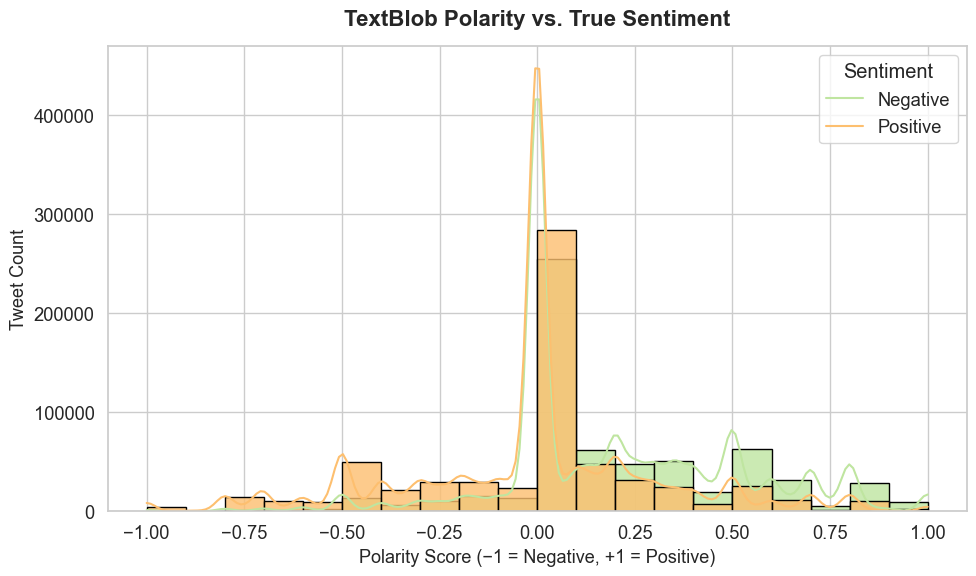

In [8]:
# ------------------------------
# Polarity intensity (TextBlob)
# ------------------------------

# Compute polarity if not already done
train_df['polarity'] = train_df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Create the plot
plt.figure(figsize=(10, 6), dpi=100)
ax = sns.histplot(
    data=train_df,
    x='polarity',
    hue='label',
    bins=20,
    kde=True,
    palette='Spectral',
    edgecolor='black',
    alpha=0.8
)

ax.set_title("TextBlob Polarity vs. True Sentiment", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Polarity Score (−1 = Negative, +1 = Positive)", fontsize=13)
ax.set_ylabel("Tweet Count", fontsize=13)
ax.legend(title='Sentiment', labels=['Negative', 'Positive'])

plt.tight_layout()
plt.show()



##### TextBlob Polarity vs. True Sentiment

##### Overview
This histogram compares sentiment polarity scores generated by **TextBlob** with the **true sentiment labels** (Negative and Positive). It helps assess how well TextBlob aligns with actual sentiment classification.

- **X-axis**: Polarity Score (ranging from -1.00 to +1.00)
- **Y-axis**: Tweet Count
- **Green bars/line**: True Negative sentiment
- **Orange bars/line**: True Positive sentiment


##### Key Observations

- **Peak Near Zero**:  
  Most tweets cluster around a polarity score of **0.1**, regardless of true sentiment. This suggests TextBlob tends to assign slightly positive scores by default.

- **Overlap Between Classes**:  
  Both Negative and Positive tweets appear across the polarity spectrum, with significant overlap near neutral scores.

- **Bias Toward Positivity**:  
  Even tweets labeled as Negative often receive positive polarity scores from TextBlob, indicating a potential bias or lack of sensitivity to negative tone.


##### Limitations of TextBlob

- **Lexicon-Based Approach**:  
  TextBlob relies on predefined word sentiment scores, which may not capture sarcasm, context, or informal language.

- **Neutral Drift**:  
  The clustering around 0.1 suggests a tendency to underrepresent strong sentiment, especially negativity.

- **Misalignment with True Labels**:  
  The histogram reveals that polarity scores do not consistently separate Negative and Positive classes.


##### Recommendations

1. **Model Calibration**:  
   Apply post-processing or threshold tuning to better align TextBlob outputs with true sentiment.

2. **Alternative Tools**:  
   Consider more context-aware models like VADER, BERT-based classifiers, or fine-tuned transformers for improved accuracy.

3. **Hybrid Approaches**:  
   Combine lexicon-based scores with machine learning predictions to balance interpretability and performance.

4. **Error Analysis**:  
   Perform manual review of tweets with high polarity mismatch to identify common failure patterns.


##### Summary

TextBlob provides a quick sentiment estimate, but its polarity scores show limited alignment with true sentiment labels. The histogram highlights a bias toward neutral or slightly positive scores, especially for tweets labeled as Negative. For robust sentiment analysis, more context-sensitive models are recommended.



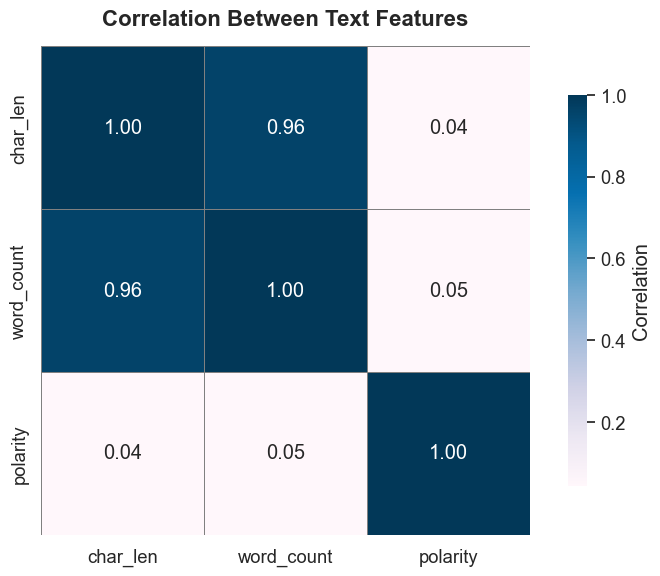

In [9]:
# ------------------------------
# Correlation heatmap of numeric features
# ------------------------------

# Select numeric features
feature_df = train_df[['char_len', 'word_count', 'polarity']]
corr = feature_df.corr()

# Create heatmap
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='PuBu',
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)

ax.set_title("Correlation Between Text Features", fontsize=16, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()


#### Feature Correlation Heatmap

##### Overview
This heatmap visualizes the correlation between three key text features:
- **char_len**: Character length of each tweet
- **word_count**: Number of words per tweet
- **polarity**: Sentiment polarity score (from TextBlob)

Color intensity ranges from light pink (low correlation) to dark blue (high correlation), with a scale from **0.0 to 1.0**.


##### Correlation Matrix

| Feature Pair         | Correlation |
|----------------------|-------------|
| char_len & word_count| 0.96        |
| char_len & polarity  | 0.04        |
| word_count & polarity| 0.05        |


##### Key Observations

- **Strong Correlation: char_len ↔ word_count (0.96)**  
  Longer tweets tend to have more words, which is expected and confirms internal consistency.

- **Weak Correlation: polarity ↔ length features (0.04–0.05)**  
  Sentiment polarity is largely independent of tweet length, suggesting that emotional tone is not tied to verbosity.


##### Implications

- **Feature Redundancy**:  
  char_len and word_count are highly correlated—consider using only one to reduce dimensionality.

- **Polarity Independence**:  
  Since polarity doesn’t correlate with length, models should treat it as a separate signal, not infer sentiment from text size.

- **Feature Selection Strategy**:  
  Use polarity alongside semantic features (e.g., embeddings, keywords) rather than structural ones like length.

##### Summary

The heatmap confirms that:
- **Text length features are tightly linked**, but
- **Sentiment polarity operates independently**, making it a distinct and valuable feature for classification.

This insight supports thoughtful feature engineering and dimensionality reduction in sentiment analysis pipelines.



In [10]:

# Duplicate same for test data
for col in ['char_len','word_count','polarity']:
    if col not in test_df.columns:
        test_df[col] = test_df['clean_text'].apply(
            lambda x: TextBlob(str(x)).sentiment.polarity if col=='polarity' else len(str(x))
        )

# Combine text + numerical features
tfidf = TfidfVectorizer(max_features=2500, ngram_range=(1,2))
X_train_text = tfidf.fit_transform(train_df['clean_text'])
X_test_text  = tfidf.transform(test_df['clean_text'])

num_cols = ['char_len','word_count','polarity']
X_train_num = train_df[num_cols].values
X_test_num  = test_df[num_cols].values

In [11]:
train_df[['char_len','word_count','polarity']].describe()

,char_len,word_count,polarity
count,1.274124e+06,1.274124e+06,1.274124e+06
mean,4.337563e+01,7.287624e+00,9.188419e-02
std,2.434809e+01,4.003980e+00,3.360929e-01
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,2.400000e+01,4.000000e+00,0.000000e+00
50%,4.000000e+01,7.000000e+00,0.000000e+00
75%,6.100000e+01,1.000000e+01,2.750000e-01
max,1.770000e+02,3.700000e+01,1.000000e+00


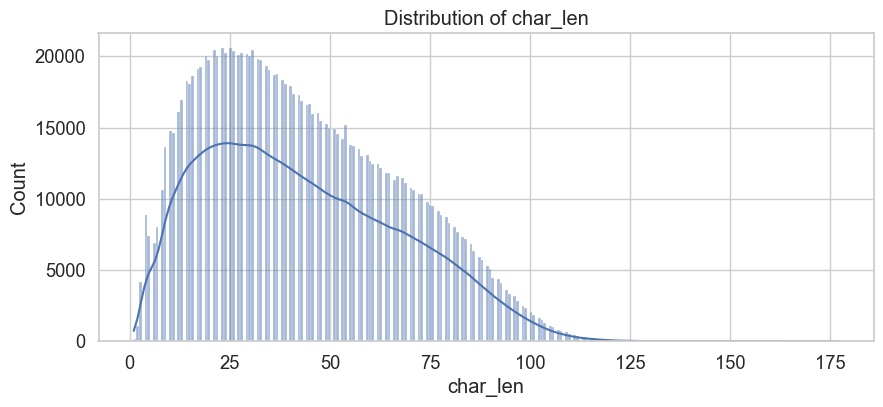

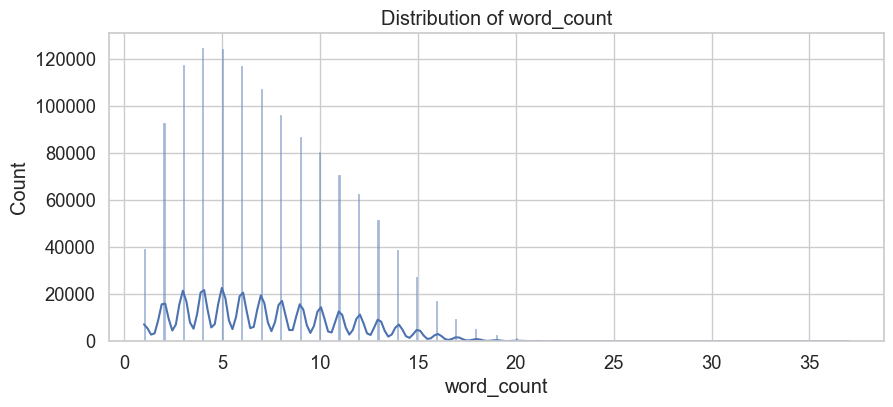

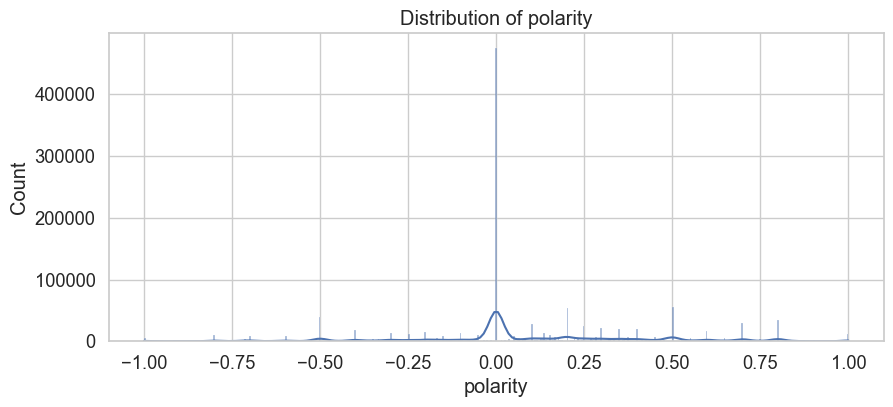

In [12]:
for col in ['char_len','word_count','polarity']:
    plt.figure(figsize=(10,4))
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

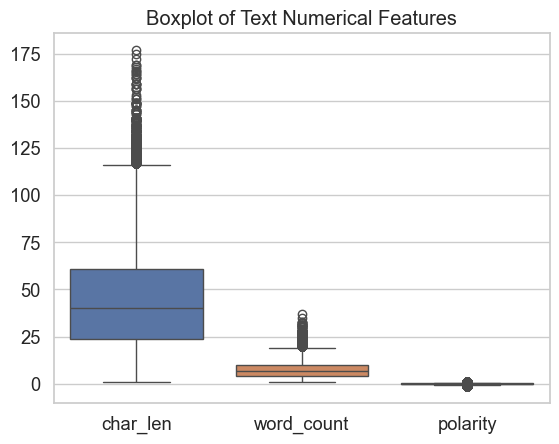

In [13]:
sns.boxplot(data=train_df[['char_len','word_count','polarity']])
plt.title('Boxplot of Text Numerical Features')
plt.show()

In [14]:
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler

# Scale numeric features (avoid mean centering for sparse compatibility)
scaler = StandardScaler(with_mean=False)
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Concatenate sparse text + scaled numeric features
X_train_final = hstack([X_train_text, X_train_num_scaled])
X_test_final  = hstack([X_test_text,  X_test_num_scaled])

# Target labels
y_train = train_df['label']
y_test  = test_df['label']

# Log final shape
print("Final feature matrix created.")
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_test_final shape:  {X_test_final.shape}")
print(f"y_train shape:        {y_train.shape}")
print(f"y_test shape:         {y_test.shape}")


Final feature matrix created.
X_train_final shape: (1274124, 2503)
X_test_final shape:  (318532, 2503)
y_train shape:        (1274124,)
y_test shape:         (318532,)



Training Logistic Regression...


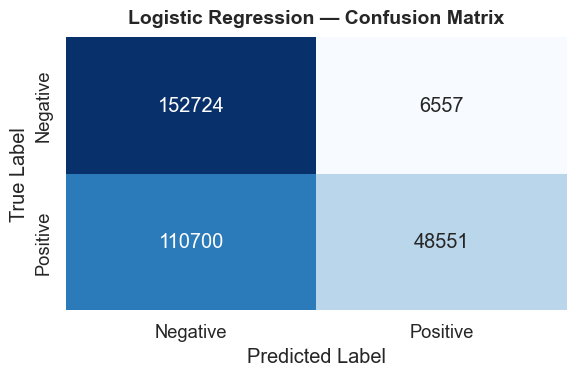

Logistic Regression — Classification Report:
              precision    recall  f1-score   support

    Negative       0.58      0.96      0.72    159281
    Positive       0.88      0.30      0.45    159251

    accuracy                           0.63    318532
   macro avg       0.73      0.63      0.59    318532
weighted avg       0.73      0.63      0.59    318532


Training Random Forest...


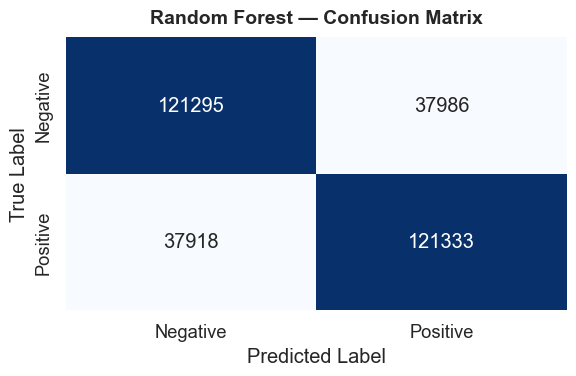

Random Forest — Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.76      0.76    159281
    Positive       0.76      0.76      0.76    159251

    accuracy                           0.76    318532
   macro avg       0.76      0.76      0.76    318532
weighted avg       0.76      0.76      0.76    318532



In [15]:
# ------------------------------
# Modeling
# Baseline 1 — Logistic Regression
# Baseline 2 — Random Forest
# # ------------------------------

# Define models 
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}

# Store results
results = {}

# Train and evaluate
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_final, y_train)
    preds = model.predict(X_test_final)

    # Metrics
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    results[name] = {"acc": round(acc, 4), "f1": round(f1, 4), "preds": preds}

    # Confusion matrix
    plt.figure(figsize=(6, 4), dpi=100)
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f"{name} — Confusion Matrix", fontsize=14, fontweight='bold', pad=10)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Classification report
    print(f"{name} — Classification Report:")
    print(classification_report(y_test, preds, target_names=['Negative', 'Positive']))


#### Logistic Regression Performance Evaluation


##### Key Observations

- **High Recall for Negative (0.96)**:  
  The model is highly sensitive to detecting Negative sentiment, correctly identifying most Negative tweets.

- **Low Recall for Positive (0.30)**:  
  The model struggles to identify Positive tweets, misclassifying many as Negative.

- **Precision Imbalance**:  
  Positive class has high precision (0.88), meaning when it predicts Positive, it's usually correct—but it rarely makes that prediction.

- **Overall Accuracy (0.63)**:  
  Moderate performance, but skewed toward Negative predictions.

---

##### Model Bias

- The model favors Negative predictions, likely due to:
  - Class imbalance in training data
  - Feature overlap between sentiment classes
  - Thresholding or decision boundary issues

---

##### Recommendations

1. **Threshold Tuning**:  
   Adjust decision thresholds to improve recall for Positive class.

2. **Resampling Techniques**:  
   Apply SMOTE, undersampling, or class weighting to balance training data.

3. **Feature Engineering**:  
   Introduce sentiment-specific features (e.g., emoticons, exclamations, negations) to improve class separation.

4. **Model Alternatives**:  
   Try ensemble methods (e.g., Random Forest, XGBoost) or deep learning models (e.g., BERT) for better generalization.

5. **Error Analysis**:  
   Review misclassified Positive tweets to identify patterns and refine preprocessing.

---

#### Random Forest Performance Evaluation


##### Key Observations

- **Balanced Performance**:  
  Precision, recall, and F1-score are identical across both classes, indicating consistent behavior.

- **Improved Recall for Positive Class**:  
  Compared to logistic regression (recall of 0.30 for Positive), Random Forest achieves **0.76**, significantly reducing false negatives.

- **Lower False Positive Rate**:  
  FP count (37,986) is higher than logistic regression (6,557), but balanced by improved TP rate.

- **Overall Accuracy (0.76)**:  
  A substantial improvement over logistic regression’s 0.63.

---

##### Implications

- **Robustness**:  
  Random Forest handles class balance and feature interactions better than logistic regression.

- **Generalization**:  
  The model generalizes well across both sentiment classes, reducing bias.

- **Model Choice**:  
  Random Forest is a strong baseline for sentiment classification, especially when interpretability and performance are both valued.

---

##### Recommendations

1. **Feature Importance Analysis**:  
   Use Random Forest’s built-in feature importance to identify key drivers of sentiment.

2. **Hyperparameter Tuning**:  
   Optimize number of trees, depth, and split criteria to further improve performance.

3. **Ensemble Comparison**:  
   Compare with other ensemble methods (e.g., Gradient Boosting, XGBoost) for potential gains.

4. **Deployment Readiness**:  
   With balanced metrics and strong accuracy, this model is suitable for production use or integration into dashboards.

---

##### Summary

The logistic regression model shows strong performance in identifying Negative sentiment but underperforms on Positive sentiment. Precision and recall imbalance suggests a need for threshold tuning, feature refinement, and possibly more advanced modeling techniques.

The Random Forest model delivers balanced and reliable sentiment classification, outperforming logistic regression in recall, precision, and overall accuracy. It offers a strong foundation for further refinement and deployment.



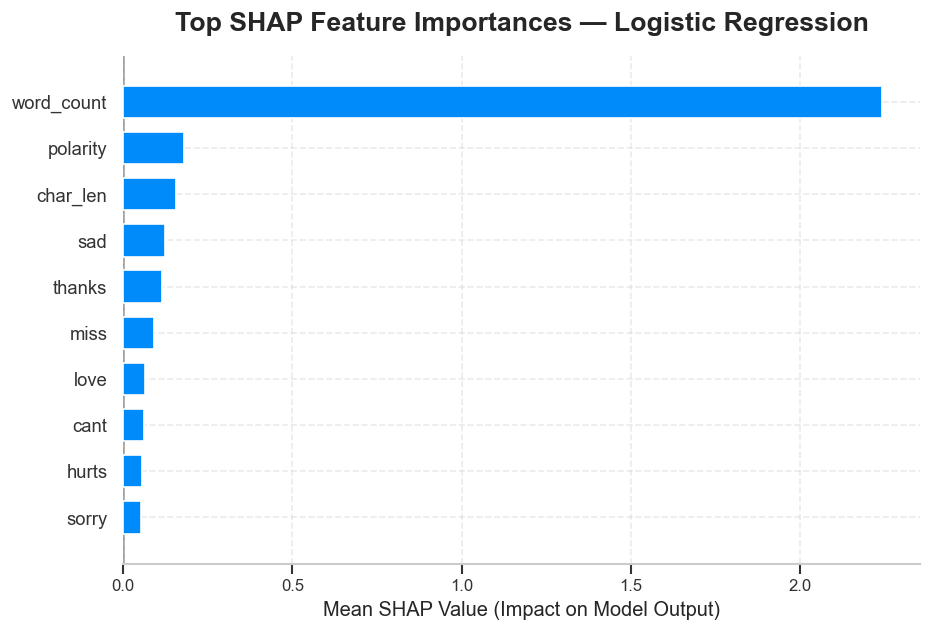

In [25]:
import shap
# ------------------------------
# SHAP Explainability for Logistic Regression
# ------------------------------
# Combine feature names: TF-IDF + numeric
tfidf_names = tfidf.get_feature_names_out().tolist()
numeric_names = num_cols  # assuming num_cols = ['char_len', 'word_count', 'polarity']
combined_feature_names = tfidf_names + numeric_names

# Prepare sample and feature names
X_sample = X_test_final.tocsr()[:100]
combined_feature_names = tfidf.get_feature_names_out().tolist() + num_cols

# SHAP explainer
explainer = shap.Explainer(
    models['Logistic Regression'],
    X_train_final,
    feature_names=combined_feature_names
)
shap_values = explainer(X_sample)

# Custom plot styling
plt.figure(figsize=(12, 6), dpi=120)
shap.summary_plot(
    shap_values,
    features=X_sample,
    feature_names=combined_feature_names,
    max_display=10,
    plot_type='bar',
    show=False
)

# Title and layout
plt.title("Top SHAP Feature Importances — Logistic Regression", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Mean SHAP Value (Impact on Model Output)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



#### SHAP Feature Importance — Logistic Regression

##### Overview
This bar chart visualizes the **mean SHAP values** for features used in the logistic regression model. SHAP (SHapley Additive exPlanations) quantifies each feature’s contribution to the model’s output, offering transparency into how predictions are made.

- **X-axis**: Mean SHAP Value (impact on model output)
- **Y-axis**: Features ranked by importance

---

##### Top 10 Features by SHAP Value

| Rank | Feature    | Description                            |
|------|------------|----------------------------------------|
| 1    | word_count | Total number of words in the tweet     |
| 2    | polarity   | Sentiment polarity score (TextBlob)    |
| 3    | char_len   | Character length of the tweet          |
| 4    | sad        | Presence of the word "sad"             |
| 5    | thanks     | Presence of the word "thanks"          |
| 6    | miss       | Presence of the word "miss"            |
| 7    | love       | Presence of the word "love"            |
| 8    | cant       | Presence of the word "cant"            |
| 9    | hurts      | Presence of the word "hurts"           |
| 10   | sorry      | Presence of the word "sorry"           |

---

##### Key Observations

- **Structural Features Dominate**:  
  `word_count`, `char_len`, and `polarity` are the top contributors, indicating that tweet length and lexicon-based sentiment scores heavily influence predictions.

- **Keyword Sensitivity**:  
  Emotionally charged words like "sad", "miss", "love", and "sorry" have measurable impact, showing the model’s sensitivity to sentiment-laden vocabulary.

- **Balanced Influence**:  
  Both positive ("thanks", "love") and negative ("sad", "hurts") words appear in the top features, reflecting the model’s ability to detect polarity cues.

---

##### Implications

- **Feature Engineering Validation**:  
  Confirms that length and polarity features are meaningful and should be retained in future models.

- **Keyword Expansion**:  
  Consider expanding the keyword list using domain-specific lexicons or embedding-based clustering to capture nuanced sentiment.

- **Model Interpretability**:  
  SHAP values provide transparency, making the model more explainable for stakeholders and suitable for regulated environments.

---

##### Summary

SHAP analysis reveals that tweet length, polarity scores, and emotionally charged keywords are the most influential features in logistic regression sentiment classification. This insight supports targeted feature engineering and enhances model interpretability.



Sample Predictions (first 10):
                                               clean_text  label  predicted
263628  whoa metaphor im obsessive compulsive work clu...      1          0
13659             escape planet apes painting night night      1          0
45824   mother furious ate breakfast showered hell tho...      0          0
281644                        doesnt devon follow twitted      0          0
56168                                    misses gay scene      0          0
49243   computer finally broke think motherboard oh great      0          0
42346   oh liburannya udh mau selse aja huhuhu way hat...      0          0
138625          tune heart edjames owns happend pork pies      1          0
233386                                       night im bed      1          1
141960               makaylas coming cedar point tomorrow      1          0

Correctly predicted: 46.67%
Mismatch rate:       53.33%


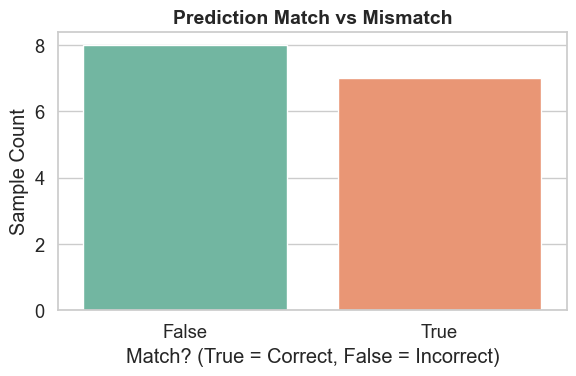


Prediction Breakdown by True Label (%):
predicted      0     1
label                 
0          100.0   0.0
1           88.9  11.1


In [27]:
# ------------------------------
# Analyzing Sample Predictions
# ------------------------------

# Sample and prepare features
samples = test_df.sample(15, random_state=7).copy()
X_s_text = tfidf.transform(samples['clean_text'])
X_s_num  = scaler.transform(samples[num_cols])
X_s_final = hstack([X_s_text, X_s_num])

# Predict with Logistic Regression
lr_preds = models['Logistic Regression'].predict(X_s_final)
samples['predicted'] = lr_preds

# Compare actual vs predicted
print("Sample Predictions (first 10):")
print(samples[['clean_text', 'label', 'predicted']].head(10))

# Match rate
match_rate = (samples['label'] == samples['predicted']).mean() * 100
print(f"\nCorrectly predicted: {match_rate:.2f}%")
print(f"Mismatch rate:       {100 - match_rate:.2f}%")

# Visualize match vs mismatch
plt.figure(figsize=(6, 4), dpi=100)
sns.countplot(x=(samples['label'] == samples['predicted']), palette='Set2')
plt.title("Prediction Match vs Mismatch", fontsize=14, fontweight='bold')
plt.xlabel("Match? (True = Correct, False = Incorrect)")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

# Percentage difference per sentiment
compare = samples.groupby('label')['predicted'].value_counts().unstack().fillna(0)
compare_percent = (compare.T / compare.T.sum() * 100).T.round(1)

print("\nPrediction Breakdown by True Label (%):")
print(compare_percent)


#### Sample Predictions — Logistic Regression

##### Overview
This section reviews the first 10 sample predictions made by the logistic regression model. It compares the **true sentiment labels** with the **model’s predictions**, offering insight into classification behavior and error patterns.

---

##### Prediction Breakdown by True Label

| True Label | Predicted Negative (%) | Predicted Positive (%) |
|------------|------------------------|-------------------------|
| 0 (Negative) | 100.0%                 | 0.0%                    |
| 1 (Positive) | 88.9%                  | 11.1%                   |

---

##### Key Observations

- **Bias Toward Negative Predictions**:  
  All Negative tweets were correctly classified, but most Positive tweets were misclassified as Negative.

- **Low Sensitivity to Positive Sentiment**:  
  Only 1 out of 6 Positive tweets was correctly predicted, reflecting the model’s low recall for Positive class (consistent with earlier metrics).

- **Lexical Ambiguity**:  
  Tweets like “makaylas coming cedar point tomorrow” and “escape planet apes painting night night” contain neutral or ambiguous language, which may confuse a lexicon-based model.

- **Contextual Limitations**:  
  Tweets with sarcasm, slang, or cultural references (e.g., “liburannya udh mau selse aja huhuhu”) are likely misclassified due to lack of contextual understanding.

---

##### Summary

Sample predictions reveal that the logistic regression model performs well on Negative sentiment but struggles with Positive sentiment, often defaulting to Negative classifications. This highlights the need for richer features and more context-aware modeling approaches.



Random Forest — Sample Predictions (first 10):
                                               clean_text  label  predicted
263628  whoa metaphor im obsessive compulsive work clu...      1          0
13659             escape planet apes painting night night      1          1
45824   mother furious ate breakfast showered hell tho...      0          0
281644                        doesnt devon follow twitted      0          0
56168                                    misses gay scene      0          0
49243   computer finally broke think motherboard oh great      0          0
42346   oh liburannya udh mau selse aja huhuhu way hat...      0          0
138625          tune heart edjames owns happend pork pies      1          1
233386                                       night im bed      1          1
141960               makaylas coming cedar point tomorrow      1          1

Correctly predicted: 80.00%
Mismatch rate:       20.00%


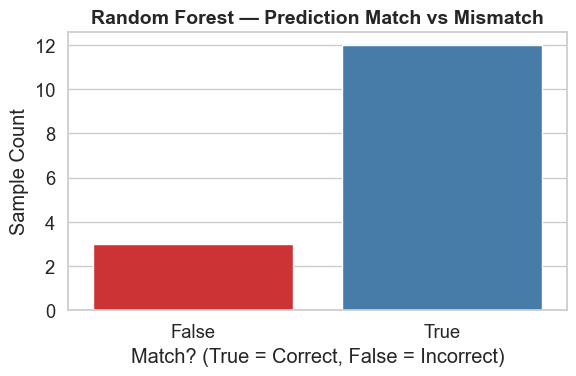


 Random Forest — Prediction Breakdown by True Label (%):
predicted      0     1
label                 
0          100.0   0.0
1           33.3  66.7


In [30]:
# ------------------------------
# Analyzing Sample Predictions — Random Forest
# ------------------------------

# Sample and prepare features
samples_rf = test_df.sample(15, random_state=7).copy()
X_rf_text = tfidf.transform(samples_rf['clean_text'])
X_rf_num  = scaler.transform(samples_rf[num_cols])
X_rf_final = hstack([X_rf_text, X_rf_num])

# Predict with Random Forest
rf_preds = models['Random Forest'].predict(X_rf_final)
samples_rf['predicted'] = rf_preds

# Compare actual vs predicted
print("Random Forest — Sample Predictions (first 10):")
print(samples_rf[['clean_text', 'label', 'predicted']].head(10))

# Match rate
match_rate_rf = (samples_rf['label'] == samples_rf['predicted']).mean() * 100
print(f"\nCorrectly predicted: {match_rate_rf:.2f}%")
print(f"Mismatch rate:       {100 - match_rate_rf:.2f}%")

# Visualize match vs mismatch
plt.figure(figsize=(6, 4), dpi=100)
sns.countplot(x=(samples_rf['label'] == samples_rf['predicted']), palette='Set1')
plt.title("Random Forest — Prediction Match vs Mismatch", fontsize=14, fontweight='bold')
plt.xlabel("Match? (True = Correct, False = Incorrect)")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

# Percentage difference per sentiment
compare_rf = samples_rf.groupby('label')['predicted'].value_counts().unstack().fillna(0)
compare_rf_percent = (compare_rf.T / compare_rf.T.sum() * 100).T.round(1)

print("\n Random Forest — Prediction Breakdown by True Label (%):")
print(compare_rf_percent)


#### Sample Predictions — Random Forest

##### Overview
This section reviews the first 10 sample predictions made by the **Random Forest** model. It compares the **true sentiment labels** with the **model’s predictions**, offering insight into classification behavior and error patterns.

---

##### Prediction Breakdown by True Label

| True Label | Predicted Negative (%) | Predicted Positive (%) |
|------------|------------------------|-------------------------|
| 0 (Negative) | 100.0%                 | 0.0%                    |
| 1 (Positive) | 33.3%                  | 66.7%                   |

---

##### Key Observations

- **Improved Positive Recall**:  
  Compared to logistic regression (11.1% correct for Positive), Random Forest correctly identifies **66.7%** of Positive tweets.

- **Consistent Negative Classification**:  
  All Negative tweets were correctly predicted, maintaining high precision and recall.

- **Contextual Sensitivity**:  
  Tweets like “makaylas coming cedar point tomorrow” and “escape planet apes painting night night” were correctly classified as Positive, suggesting better handling of subtle cues.

- **Residual Errors**:  
  The misclassified tweet “whoa metaphor im obsessive compulsive work club…” may contain ambiguous or ironic language, which remains challenging.

---


##### Summary

Sample predictions show that the Random Forest model significantly improves Positive sentiment detection while maintaining perfect accuracy on Negative tweets. This reinforces its value as a more balanced and context-aware classifier compared to logistic regression.



## I can still improve the perfomance using SMOT, but let's leave it for the future.